In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from vit_pytorch import ViT
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from timer import Timer
import numpy as np
from sklearn import metrics
%matplotlib inline

In [2]:
def count_parameters(model):
    """ Counts the number of trainable parameters

    Args:
        model (object): A PyTorch model.

    Returns:
        int: The number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:

class MLPNet(nn.Module):
    """ Creates a fully connected multilayer perceptron. Derived from the PyTorch nn.Module class.
    """

    def __init__(self, image_size, num_classes, channels):
        """ Initializes the model

        Args:
            image_size (array): The resolution of the image
            num_classes (int): The number of output classes
            channels (int): The color depth of the image
        """
        super(MLPNet, self).__init__()
        
        self.fc1 = nn.Linear(image_size * channels, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        """ Performs inference on an image

        Args:
            x (array): The image

        Returns:
            array: The prediction distribution
        """
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)

        output = F.log_softmax(x, dim=1)
        return output  

In [4]:
class CNNNet(nn.Module):
    """ Creates a convolutional neural network. Derived from the PyTorch nn.Module class.
    """

    def __init__(self, image_size, num_classes, channels, ):
        """ Initializes the model

        Args:
            image_size (tuple): The height and width of the image
            num_classes (int): The number of output classes
            channels (int): The color depth of the image
        """
        
        super(CNNNet, self).__init__()

        (image_height, image_width) = image_size
        self.dropout = nn.Dropout(0.25)
        
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.norm3 = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)

        fc_size = self.forward(torch.rand((1, channels, image_height, image_width)), True)

        self.fc1 = nn.Linear(fc_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x, get_fc_size=False):
        """ Performs inference on an image

        Args:
            x (array): The image
            get_fc_size (bool): Flag that determines the flattened size of the last convolutional layer

        Returns:
            array: The prediction distribution
        """
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)

        if get_fc_size:
            return x.nelement()

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [5]:
class ViTNet(nn.Module): 
    """ Creates a vision transformer. Derived from the PyTorch nn.Module class.
    """
    
    def __init__(self, image_size, patch_size, num_classes, channels):
        """ Initializes the model

        Args:
            image_size (array): The resolution of the image
            patch_size (int): The size (patch_size x patch_size) of the patches to extract from the image 
            num_classes (int): The number of output classes
            channels (int): The color depth of the image
        """
        HIDDEN_SIZE = 768
        DEPTH = 6
        HEADS = 12
        MLP_DIM = 3072
        
        super(ViTNet, self).__init__()
        
        self.model = ViT(
                        image_size = image_size,
                        patch_size = patch_size,
                        num_classes = num_classes,
                        dim = HIDDEN_SIZE,
                        depth = DEPTH,
                        heads = HEADS,
                        mlp_dim = MLP_DIM,
                        channels = channels,
                        dropout = 0.1,
                        emb_dropout = 0.1
                        )

    def forward(self, x):
        """ Performs inference on an image

        Args:
            x (array): The image

        Returns:
            array: The prediction distribution
        """
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
class HybridNet(nn.Module):
    """ Creates a CNN connected to a ViT. Derived from the PyTorch nn.Module class.
    """

    def __init__(self, image_size, channels, num_classes):
        """ Initializes the model

        Args:
            image_size (array): The resolution of the image
            channels (int): The color depth of the image
            num_classes (int): The number of output classes
        """
        HIDDEN_SIZE = 768
        DEPTH = 6
        HEADS = 12
        MLP_DIM = 3072

        super(HybridNet, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(0.25)

        image_width = int((math.sqrt(image_size) - 4) / 2)

        self.vit = ViT(
                        image_size = image_width ** 2,
                        patch_size = int(image_width / 2),
                        num_classes = num_classes,
                        dim = HIDDEN_SIZE,
                        depth = DEPTH,
                        heads = HEADS,
                        mlp_dim = MLP_DIM,
                        channels = 64,
                        dropout = 0.1,
                        emb_dropout = 0.1
                        )

    def forward(self, x):
        """ Performs inference on an image

        Args:
            x (array): The image

        Returns:
            array: The prediction distribution
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.norm2(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = self.vit(x)

        output = F.log_softmax(x, dim=1)
        return output

In [7]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    """ Performs a single iteration of training

    Args:
        model (object): The model to train
        device (object): The device that will host the training
        train_loader (object): The training dataset
        optimizer (object): The optimization algorithm
        epoch (int): The current epoch
        log_interval (int): The frequency to log data to the screen
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
def test(model, device, test_loader, dataset, model_type, writer, epoch):
    """_summary_

    Args:
        model (object): The model to test
        device (object): The device that will host the testing
        test_loader (object): The test dataset
        dataset (string): The name of the dataset to use in testing
        model_type (string): The type of the model to test
        writer (object): Tensorboard logger
        epoch (int): The current epoch in training

    Returns:
        accuracy (): 
        actual ():
        predicted (): 
    """
    model.eval()
    test_loss = 0
    correct = 0
    actual = []
    predicted = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            with Timer("{} {}".format(model_type, dataset)):
                output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            actual.extend(target.cpu().numpy())
            predicted.extend([np.argmax(pred) for pred in output.cpu().numpy()])

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    writer.add_scalar('Accuracy/{} {}'.format(model_type, dataset), accuracy, epoch)
    return accuracy, actual, predicted

In [9]:
# The models and datasets that we'll be evaluating

MODEL_TYPES = ["MLP", "CNN", "ViT", "HYBRID"]
DATASETS    = ["MNIST", "CIFAR10", "CIFAR100"] 
#MODEL_TYPES = ["MLP"]
#DATASETS    = ["MNIST"] 

In [10]:
def run(batch_size, test_batch_size, lr, gamma, epochs, log_dir, log_interval):
    """ Performs training and testing for all models and datasets specified above 

    Args:
        batch_size (int): The training batch size
        test_batch_size (int): The test batch size
        lr (float): The learning rate
        gamma (float): _description_
        epochs (int): The number of epochs of training
        log_dir (_type_): The directory for the logs
        log_interval (int): How frequently to log to the screen

    Returns:
        accuracies (dictionary): The model accuracies by model type and dataset
        parameters (dictionary): The number of trainable parameters in each model
        expected_vs_actual (dictionary): The expected and actual values used in testing each of the models
    """
    # Determine if we should use a GPU
    use_cuda = torch.cuda.is_available()

    # Reduce precision to speed up training
    torch.set_float32_matmul_precision('medium')

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs  = {'batch_size': test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    accuracies = {}
    parameters = {}
    expected_vs_actual = {}
    
    for dataset in DATASETS:
        if dataset == "MNIST":
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307), (0.3081))
            ])
            train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
            test_set = datasets.MNIST('./data', train=False, transform=transform)
            image_height = 28
            image_width = 28
            patch_size = 14
            num_classes = 10
            channels = 1
        elif dataset == "CIFAR10":
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
            train_set = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
            test_set = datasets.CIFAR10('./data', train=False, transform=transform)
            image_height = 32
            image_width = 32
            patch_size = 16
            num_classes = 10
            channels = 3
        elif dataset == "CIFAR100":
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
            train_set = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
            test_set = datasets.CIFAR100('./data', train=False, transform=transform)
            image_height = 32
            image_width = 32
            patch_size = 16
            num_classes = 100
            channels = 3

        for model_type in MODEL_TYPES:
            print("Evaluating {} with {}".format(model_type, dataset))

            train_loader = torch.utils.data.DataLoader(train_set,**train_kwargs)
            test_loader  = torch.utils.data.DataLoader(test_set, **test_kwargs)

            if model_type == "MLP":
                model = MLPNet(image_height * image_width, num_classes, channels).to(device)
            elif model_type == "CNN":
                model = CNNNet((image_height, image_width), num_classes, channels).to(device)
            elif model_type == "ViT":
                model = ViTNet(image_height * image_width, patch_size, num_classes, channels).to(device)
            elif model_type == "HYBRID":
                model = HybridNet(image_height * image_width, channels, num_classes).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

            max_accuracy = 0
            writer = SummaryWriter(log_dir=log_dir)
            for epoch in range(1, epochs + 1):
                train(model, device, train_loader, optimizer, epoch, log_interval)
                accuracy, actual, predicted = test(model, device, test_loader, dataset, model_type, writer, epoch)
                max_accuracy = max(accuracy, max_accuracy)
                scheduler.step()
                if (max_accuracy > 98):
                    print('Breaking at epoch {}'.format(epoch))
                    break

            accuracies[f'{model_type} {dataset}'] = max_accuracy
            parameters[f'{model_type} {dataset}'] = count_parameters(model)
            expected_vs_actual[f'{model_type} {dataset}'] = (actual, predicted)

            torch.save(model.state_dict(), "{}_{}.pt".format(model_type, dataset))

    return accuracies, parameters, expected_vs_actual

In [11]:
batch_size      = 64             # Input batch size for training (default: 64)
epochs          = 20             # Number of epochs to train (default: 15)
lr              = .00001         # Learning rate (default: .00001)
gamma           = 0.7            # Learning rate step gamma (default: 0.7)
test_batch_size = 1000           # Input batch size for testing (default: 1000)
log_dir         = "./logs/tb"    # TF log dir (default: "./logs/tb")
log_interval    = 100            # How many batches to wait before logging training status (default: 10)

accuracies, parameters, expected_vs_actual = run(batch_size, test_batch_size, lr, gamma, epochs, log_dir, log_interval)

Evaluating MLP with MNIST
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311567
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.289753
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.271456
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.242337
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.175176
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.132953
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.070573
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.952309
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.795273
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.657328

Test set: Average loss: 1.4390, Accuracy: 6651/10000 (67%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.651304
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.472561
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.476192
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.494519
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.332273
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.165700
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.203763
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.158606
Train Epoch: 2 [51200/600

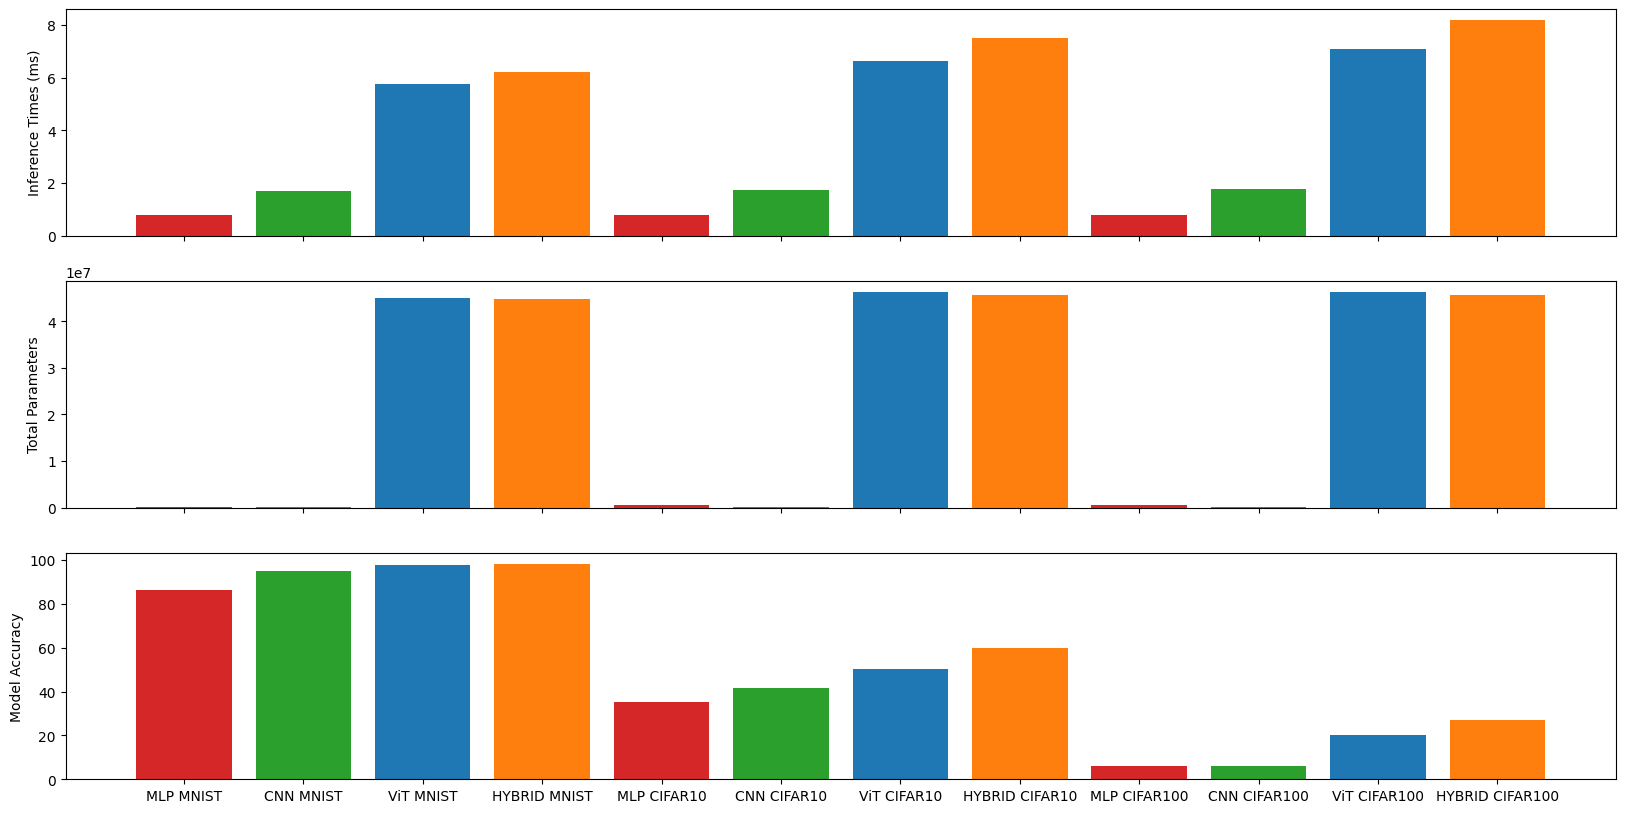

In [12]:
# Plot the collected metrics
times = Timer.times()
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))
bar_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
ax1.bar(list(times.keys()), list(times.values()), color=bar_colors)
ax1.set_ylabel('Inference Times (ms)')
ax2.bar(list(times.keys()), list(parameters.values()), color=bar_colors)
ax2.set_ylabel('Total Parameters')
ax3.bar(list(times.keys()), list(accuracies.values()), color=bar_colors)
ax3.set_ylabel('Model Accuracy')
plt.show()

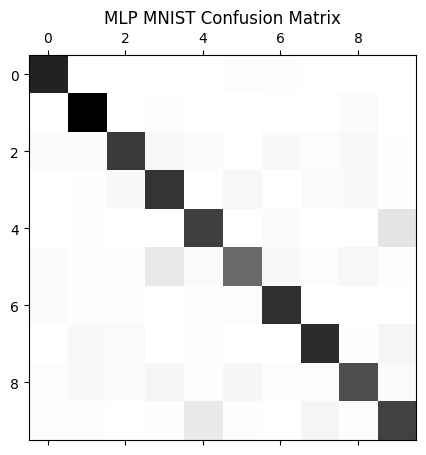

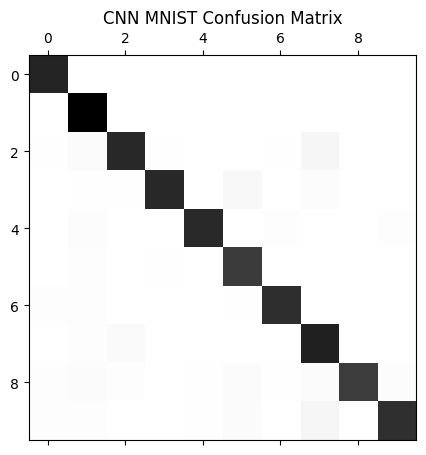

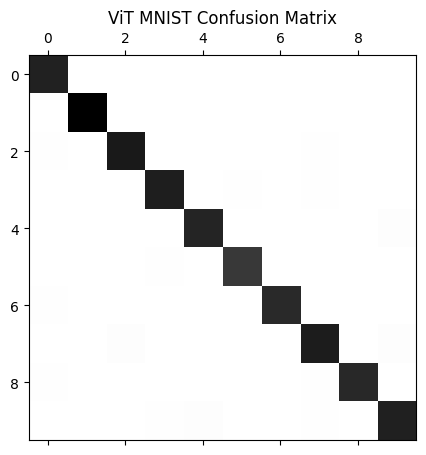

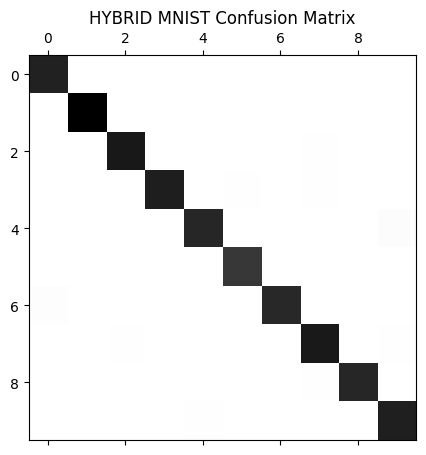

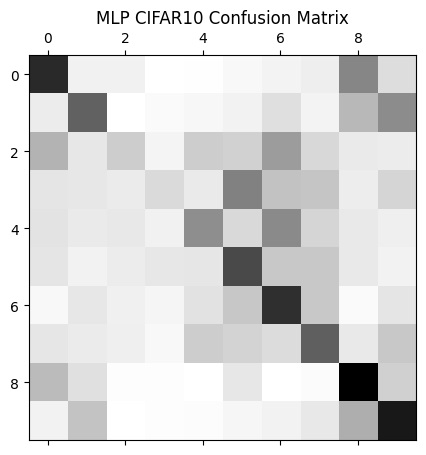

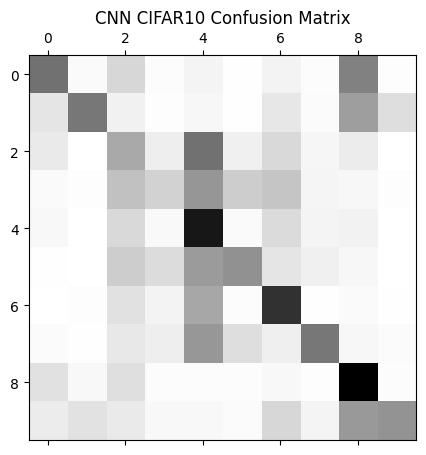

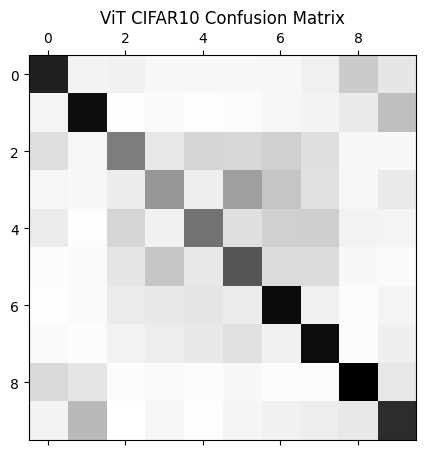

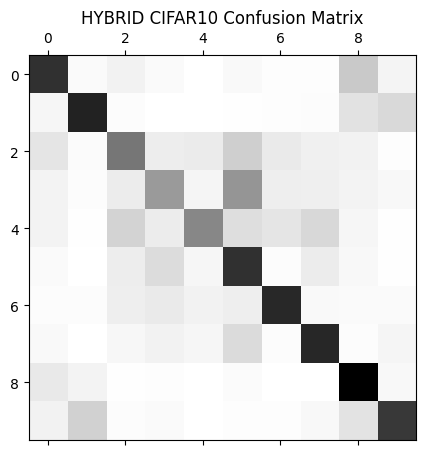

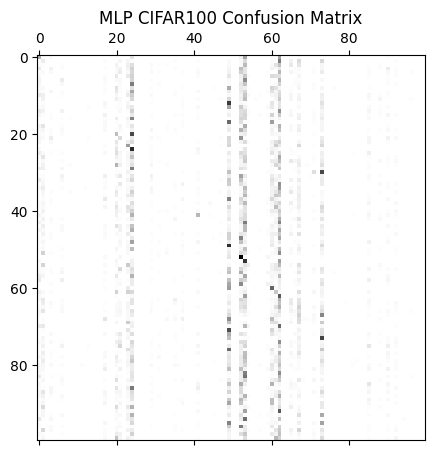

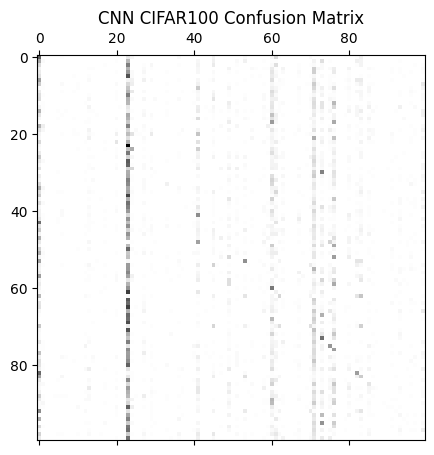

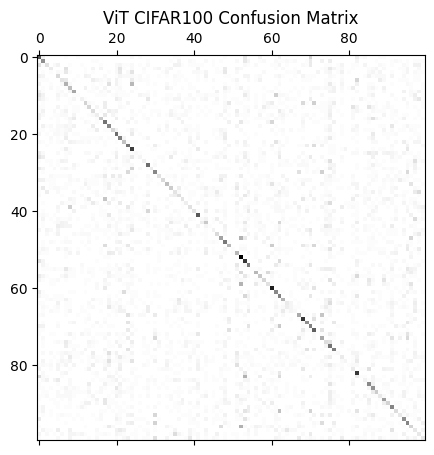

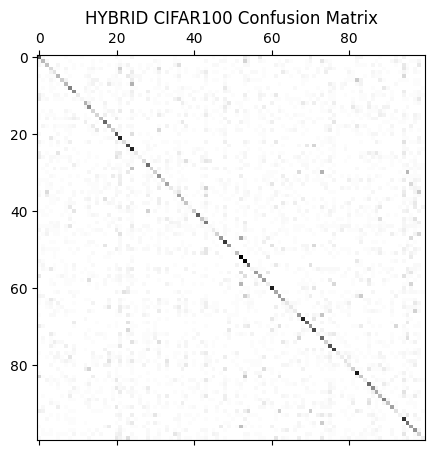

In [ ]:
# Plot the confusion matrix
for key, (actual, predicted) in expected_vs_actual.items():
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
    ax1.set_title(f'{key} Confusion Matrix')
    cm = metrics.confusion_matrix(actual, predicted)
    ax1.matshow(cm, cmap='binary', interpolation=None, aspect='auto')